<a href="https://colab.research.google.com/github/AfraAd/CSC413-Homeworks/blob/main/Fall25_Hw5_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5 - Convolutional Neural Networks
CSC413/2516: Neural Networks and Deep Learning

As with previous homeworks, replace "## Your Code" lines with your implementation.


In this homework you will implement the convolution operation from scratch, do convolution arithmetic (receptive field, number of parameters), and implement a convolutional neural network in PyTorch. While you are not allowed to use PyTorch in the first section, you are allowed to use it in the third part of the homework.
- Convolution from scratch (1 point)
- Convolution arithmetic (2.05 points)
- Convolutional neural network in PyTorch (3.45 points)

Make sure to connect to GPU for the training part (Runtime -> Change runtime -> Select T4 GPU)


In [29]:
import importlib.util

packages = ['torch', 'torchvision', 'datasets']
missing = [pkg for pkg in packages if importlib.util.find_spec(pkg) is None]

if missing:
    import subprocess
    import sys
    print(f"Installing missing packages: {', '.join(missing)}")
    subprocess.check_call([sys.executable, "-m", "pip", "install"] + missing)

In [30]:
import numpy as np
from typing import Dict, Tuple, List
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from datasets import load_dataset


## Implement the convolution operation from scratch

In [31]:
def output_shape_of_conv(
    image_height: int,
    image_width: int,
    kernel_height: int,
    kernel_width: int,
    padding: int,
    stride: int,
) -> tuple[int, int]:
    """Compute the output shape of a convolutional layer given the input shape and the kernel shape."""
    out_height, out_width = 0, 0
    ##########################################
    ## TODO: Implement the output shape computation, 0.2 points
    out_height = image_height + 2 * padding - kernel_height + 1
    out_width = image_width + 2 * padding - kernel_width + 1
    ##########################################
    return out_height, out_width


def convolution(
    image: np.typing.ArrayLike,
    kernel: np.typing.ArrayLike,
    padding: int = 0,
    stride: int = 1,
) -> np.typing.ArrayLike:
    """Perform a convolution operation on the image with the kernel using padding and stride. Use the traditional definition of convolution (not cross-correlation).
    Images are grayscale and of shape  (H, W), H=height, W=width."""
    res = np.zeros(
        output_shape_of_conv(
            image.shape[0],
            image.shape[1],
            kernel.shape[0],
            kernel.shape[1],
            padding,
            stride,
        )
    )
    ##########################################
    ## TODO: Implement the convolution operation, 0.6 points
    ## Your code will be tested with different padding and stride values
    ## 1. Apply padding to the image
    ## Hint: You can use np.pad
    input = np.pad(image, ((padding, padding), (padding, padding)), "constant")
    ## 2. Implement the convolution operation on the padded image
    ## Hint: Either use np.flip or carefully select the indices
    for i in range(0, res.shape[0], stride):
        for j in range(0, res.shape[1], stride):
            res[i, j] = np.sum(input[i : i + kernel.shape[0], j : j + kernel.shape[1]])
    ##########################################
    return res


### Plus Detector
Implement a 3x3 kernel that detects a "+" shape (bright cross on dark background). You will receive full points if your kernel outputs the maximum response at the center of the plus(es).

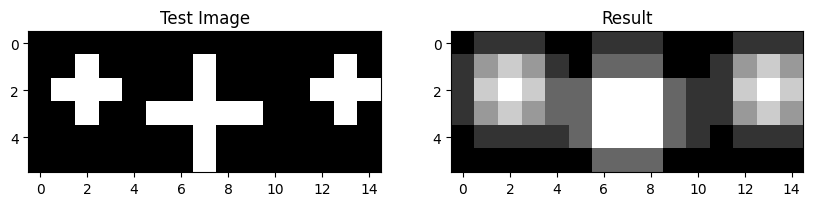

In [32]:
# Create a test image with a plus sign
test_image = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    ],
    dtype=np.float32,
)
## TODO: Implement the plus detector, 0.2 points
plus_detector = np.zeros((3, 3), dtype=np.float32)

if __name__ == "__main__":
    result = convolution(test_image, plus_detector, padding=1, stride=1)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(test_image, cmap="gray")
    axs[0].set_title("Test Image")
    axs[1].imshow(result, cmap="gray")
    axs[1].set_title("Result")
    plt.show()


## Convolutional Neural Network


## Warm-up
In this section, you will be asked to compute the parameter count and the receptive field of a given convolutional neural network.


In [33]:
def conv_layer_num_weights(
    k1: int, k2: int, in_channels: int, out_channels: int
) -> int:
    params = 0
    ##########################################
    ## TODO: Implement the parameter count (for weights) computation for a given convolutional layer, 0.05 points
    params = k1 * k2 * in_channels * out_channels
    ##########################################
    return params

def conv_layer_num_biases(
    k1: int, k2: int, in_channels: int, out_channels: int
) -> int:
    params = 0
    ##########################################
    ## TODO: Implement the parameter count (for biases) computation for a given convolutional layer, 0.05 points
    params = out_channels
    ##########################################
    return params


In the following cell, we will ask you to compute the receptive field and parameter count for three networks. For the parameter count, you are free to use the `conv_layer_num_weights` and `conv_layer_num_biases` functions. When computing the receptive field, you are free to come up with a general formula or compute it by hand, we will only test the final answer.


In [34]:
########################################################
#### Network 1
########################################################
# Imagine you have a 3-layer CNN, with the following architecture:
## Layer 1: Conv2d(3, 16, 3, 1), i.e.  out_channels=16, in_channels=3, kernel_size=3, stride=1, padding=0
## Layer 2: Conv2d(16, 32, 3, 1), i.e. out_channels=32, in_channels=16, kernel_size=3, stride=1, padding=0
## Layer 3: Conv2d(32, 64, 3, 1), i.e. out_channels=64, in_channels=32, kernel_size=3, stride=1, padding=0
def get_parameters_of_network1() -> Dict[str, int]:
    ## TODO: Compute the number of parameters in the network above, assume we don't use batch normalization or dropout.
    ## 0.25 points
    parameters = {
        "layer_1_weights": 16 * 3 * 3 * 3,
        "layer_1_biases": 16,
        "layer_2_weights": 32 * 16 * 3 * 3,
        "layer_2_biases": 32,
        "layer_3_weights": 64 * 32 * 3 * 3,
        "layer_3_biases": 64
    }
    return parameters


def get_receptive_field_for_network1() -> Dict[str, Tuple[int, int]]:
    ## TODO: Change the following values to reflect the receptive field of the network above, provide it in the form of (height, width) of the receptive field
    receptive_fields = {
        "after_layer_1": (3, 3),
        "after_layer_2": (5, 5),
        "after_layer_3": (7, 7),
    }
    return receptive_fields


########################################################
#### Network 2
########################################################
## TODO: What if the stride is 2x3 at each layer in the above network?
## Layer 1: Conv2d(3, 16, 3, (2, 3)), i.e. kernel_size=3, stride=(2, 3), padding=0
## Layer 2: Conv2d(16, 32, 3, (2, 3)), i.e. kernel_size=3, stride=(2, 3), padding=0
## Layer 3: Conv2d(32, 64, 3, (2, 3)), i.e. kernel_size=3, stride=(2, 3), padding=0
def get_receptive_field_for_network1_with_stride_2x3() -> Dict[str, Tuple[int, int]]:
    ## TODO: Change the following values
    receptive_fields = {
        "after_layer_1": (3, 3),
        "after_layer_2": (7, 9),
        "after_layer_3": (15, 27)
    }
    return receptive_fields


def get_parameters_of_network1_with_stride_2x3() -> Dict[str, int]:
    ## TODO: Compute the number of parameters in the network above, assume we don't use batch normalization or dropout.
    parameters = {
        "layer_1_weights": 432,
        "layer_1_biases": 16,
        "layer_2_weights": 4608,
        "layer_2_biases": 32,
        "layer_3_weights": 18432,
        "layer_3_biases": 64
    }
    return parameters


########################################################
#### Network 3
########################################################
# Imagine you have a 3-layer CNN, with the following architecture:
## Layer 1: Conv2d(3, 16, 5, 1) -> ReLU -> BN, i.e. kernel_size=5, stride=1, padding=1
## Layer 2: Conv2d(16, 32, 3, 2) -> ReLU -> BN, i.e. kernel_size=3, stride=2, padding=1
## Layer 3: Conv2d(32, 64, 3, 1) , i.e. kernel_size=3, stride=1, padding=1
def get_parameters_of_network3() -> Dict[str, int]:
    ## TODO: Compute the number of parameters in the network above
    parameters = {
        "layer_1_conv_weights": 16 * 3 * 5 * 5,
        "layer_1_conv_biases": 16,
        "layer_1_bn_weights": 16,
        "layer_1_bn_biases": 16,
        "layer_1_relu": 0,
        "layer_2_conv_weights": 32 * 16 * 3 * 3,
        "layer_2_conv_biases": 32,
        "layer_2_bn_weights": 32,
        "layer_2_bn_biases": 32,
        "layer_2_relu": 0,
        "layer_3_conv_weights": 64 * 32 * 3 * 3,
        "layer_3_conv_biases": 64
    }
    return parameters


def get_receptive_field_for_network3() -> Dict[str, int]:
    ## TODO: Change the following values
    receptive_fields = {
        "after_layer_1": (5, 5),
        "after_layer_2": (7, 7),
        "after_layer_3": (11, 11)
    }
    return receptive_fields


#### Convolution as a Matrix-Vector Product

We can also implement the convolution operation as a matrix product. This alternative view is useful for understanding how convolutions work mathematically and connects to how they're implemented efficiently in deep learning frameworks.

In this formulation, we reshape the input image into a column vector and construct a special matrix (called a Toeplitz matrix) where each row extracts the pixels that the kernel would multiply at one output position. The matrix-vector product then computes all output values simultaneously.



In [35]:
########################################################
#### 1D Convolution as Matrix-Vector Product
########################################################
def convolution_1d_as_matrix_vector() -> np.ndarray:
    """
    Input: x = [x1, x2, x3, x4]
    Kernel: k = [1, 0.5]
    No padding, stride=1
    """
    ## TODO: Write the convolution kernel as a matrix, 0.15 points
    matrix = np.array([1, 0.5])
    return matrix


########################################################
#### 2D Convolution as Matrix-Vector Product
########################################################
def convolution_2d_as_matrix_vector() -> np.ndarray:
    """
    Input: 4x4 image (Hint: flattened to 16x1 vector)
    Kernel: [[1, 1], [1, 1]]
    No padding, stride=2
    """
    ## TODO: Write the convolution kernel as a matrix, 0.3 points
    matrix = np.array([1, 1, 1, 1]).reshape(2, 2)

    return matrix

## Implement a CNN for the subset of CIFAR-10 dataset
In this section, you will implement a convolutional neural network using PyTorch. One of the famous datasets in the computer vision community is the CIFAR-10 dataset, and it was developed here at UofT! It consists of 60000 32x32 color images in 10 classes, with 6000 images per class. For this assignment, we will use a small subset of the CIFAR-10 Dataset with only 5 classes, available [here](https://huggingface.co/datasets/r-three/cifar10-5class-5k).

### Your Task
Build a CNN that achieves **>60% validation accuracy**. You'll implement:
1. CNN architecture (convolutional layers, batch norm, pooling, FC layer)
2. Forward pass
3. Optimizer setup
4. Training and evaluation functions

### Set-up


In [36]:
## don't change this cell
class CIFAR5Dataset(Dataset):
    """Custom Dataset wrapper for CIFAR-5 (downsampled from CIFAR-10)"""

    class_names = ["airplane", "automobile", "bird", "cat", "deer"]

    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["img"]
        label = item["label"]

        # Convert to RGB
        if image.mode != "RGB":
            image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


def visualize_cifar5(loader, num_samples=16):
    """
    Visualize samples from CIFAR5 dataset
    """
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # make_grid expects CHW, returns CHW, so permute after
    grid = torchvision.utils.make_grid(images[:num_samples])
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()


### Implement CNN
When implementing your CNN, you'll define layers in `__init__()` and use them in `forward()`. PyTorch handles the backward pass automatically


In [37]:
class CNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN, self).__init__()
        ##########################################
        ## TODO: Define your CNN architecture, 0.4 points
        ## The input tensor is of shape (batch_size, 3, 32, 32)
        ## For all conv layers assume k=3, s=1, p=1
        ## Use k=2 and s=2 for pooling layers
        ##
        ## Suggested structure:
        ## - Conv layer 1: 3 -> 16 channels
        ## - BN + ReLU + MaxPool
        ## - Conv layer 2: 16 -> 32 channels
        ## - BN + ReLU + MaxPool
        ## - Flatten
        ## - FC layer: ? -> num_classes
        ##########################################
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc = nn.Linear(32 * 8 * 8, num_classes)
        ## Optional: either define them here or use alternative functions in the forward pass
        self.flatten = None
        self.relu = None
        ##########################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        res = x
        ##########################################
        ## TODO: Implement the forward pass, 0.45 points
        ## Input tensor of shape (batch_size, 3, 32, 32)
        ## PyTorch will build the computational graph and keep track of the operations
        res = self.conv1(res)
        res = self.bn1(res)
        res = self.pool1(res)

        res = self.conv2(res)
        res = self.bn2(res)
        res = self.pool2(res)

        res = torch.flatten(res, 1)

        res = self.fc(res)
        ##########################################
        return res


## Training and Optimization
Make sure to optimize your args and "num_epochs" is less than or equal to 10. Training test case will timeout after 5 minutes, which is more than enough to achieve 65+% accuracy on this dataset.

In [38]:
args = {
    "batch_size": 1,
    "learning_rate": 1,
    "num_epochs": 1,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "optimizer": "SGD",
    "momentum": 0.9,
    "weight_decay": 0,
    "eval_interval": 100,
    "num_classes": 5,
}

In [39]:
def setup_optimizer(model, args):
    optimizer = None
    ##########################################
    ## TODO: Create the optimizer setup based on your args, 0.15 points
    ## Hint: You can use torch.optim.SGD, torch.optim.Adam, torch.optim.AdamW,
    ## torch.optim.RMSprop, etc.
    ## You are free to use any optimizer you want, with any hyperparameters you want,
    ## make sure to update `args` accordingly.
    if args["optimizer"] == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=args["learning_rate"], momentum=args["momentum"], weight_decay=args["weight_decay"])
    ##########################################
    return optimizer


def accuracy(output, target):
    acc = 0
    ##########################################
    ## TODO: Compute the accuracy of the model, should be between 0 and 1, 0.25 points
    ## Hint: output shape is (bs, n_classes)
    ## target shape: (bs, 1) or (bs, )
    ## Note: This funcion is just for you to practice, it will not be used again
    acc = torch.sum(torch.argmax(output, dim=1) == target).item() / len(target)
    # ##########################################
    return acc


In [40]:
@torch.no_grad()
def eval(model, test_loader, args):
    """
    Evaluate the model on the test set.

    Key PyTorch concepts used here:
    - @torch.no_grad(): Disables gradient computation to save memory and speed up evaluation.
      Since we're not training, we don't need gradients. This is more efficient than computing
      gradients and just not using them. And we should never train on the test/validation set!
    - model.eval(): Sets the model to evaluation mode. This affects layers like BatchNorm and
      Dropout (though we don't use Dropout here). In eval mode, BatchNorm uses running statistics
      instead of batch statistics.
    """
    model.eval()
    test_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        ## When using a gpu, we need to make sure inputs are on the same device as the model
        data, target = data.to(args["device"]), target.to(args["device"])
        loss = torch.tensor([0])
        ##########################################
        ## 0.8 points
        ## TODO: Compute the loss of the model
        ## (Hint: you first need to compute the output of the model)
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        ## TODO: Keep track of the accuracy of the model
        ## (Hint: use `correct` variable to keep track of the total number of
        ## correctly predicted data points), should be similar to your `accuracy` implementation
        correct += torch.sum(torch.argmax(output, dim=1) == target)
        ##########################################
        test_loss += loss.item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy



def torch_step(model, batch_data, batch_target, optimizer):
    """
    Perform one training step (forward pass + backward pass + parameter update).

    Key PyTorch concepts:
    - model.train(): Sets model to training mode (opposite of model.eval()). BatchNorm
      will compute statistics from the current batch.
    - optimizer.zero_grad(): Clears gradients from the previous step. PyTorch accumulates
      gradients by default, so we must clear them before each backward pass.
    - loss.item(): Extracts the scalar value from the loss tensor (converts from tensor to Python float).
      Without .item(), you'd return a tensor which keeps the entire computation graph in memory.
    """
    model.train()
    optimizer.zero_grad()
    loss = torch.tensor([0])
    ##########################################
    ## TODO: Perform a single step of gradient descent, 0.4 points
    ## 1. Compute model output
    ## 2. Compute loss: (Hint: https://docs.pytorch.org/docs/stable/nn.functional.html#loss-functions)
    ## 3. Compute gradients
    ## 4. Update parameters. The optimizer knows about all model parameters from setup_optimizer().
    output = model(batch_data)
    loss = torch.nn.functional.cross_entropy(output, batch_target)
    loss.backward()
    optimizer.step()
    ##########################################
    return loss.item()


In [41]:
def train(model, train_loader, validation_loader, args) -> Tuple[List[float], float, float]:
    model.train()
    optimizer = setup_optimizer(model, args)
    train_losses = []

    current_step = 0
    for epoch in range(args["num_epochs"]):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(args["device"]), target.to(args["device"])
            loss = torch_step(model, data, target, optimizer)
            train_losses.append(loss)

            if batch_idx % 10 == 0:
                print(
                    f"Epoch {epoch} [{batch_idx}/{len(train_loader)}] Loss: {loss:.4f}"
                )

            current_step += 1
            if current_step % args["eval_interval"] == 0:
                val_loss, val_accuracy = eval(model, validation_loader, args)
                print(
                    f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}"
                )

    return train_losses, val_loss, val_accuracy


## Train and achieve >60% accuracy on the validation set (1 point)
Make sure to optimize your `args` above.

### Data Augmentation and Preprocessing

Before training, we need to preprocess our images. **Data augmentations** create variations of training images (flips, crops) to help the model generalize better and prevent overfitting. We only augment training data - test data remains unchanged for consistent evaluation.

**Why normalize?** Neural networks train better when inputs are centered around 0.


Loading dataset...



Dataset Info:
Train samples: 5000
Test samples: 5000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer']


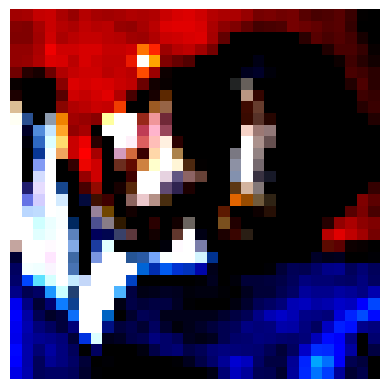

Creating model...
Epoch 0 [0/5000] Loss: 1.8905
Epoch 0 [10/5000] Loss: 27512355759849472.0000
Epoch 0 [20/5000] Loss: 75910519355743465772154880.0000
Epoch 0 [30/5000] Loss: nan
Epoch 0 [40/5000] Loss: nan
Epoch 0 [50/5000] Loss: nan
Epoch 0 [60/5000] Loss: nan
Epoch 0 [70/5000] Loss: nan
Epoch 0 [80/5000] Loss: nan
Epoch 0 [90/5000] Loss: nan
Validation Loss: nan, Validation Accuracy: 0.20
Epoch 0 [100/5000] Loss: nan
Epoch 0 [110/5000] Loss: nan
Epoch 0 [120/5000] Loss: nan
Epoch 0 [130/5000] Loss: nan
Epoch 0 [140/5000] Loss: nan
Epoch 0 [150/5000] Loss: nan
Epoch 0 [160/5000] Loss: nan
Epoch 0 [170/5000] Loss: nan
Epoch 0 [180/5000] Loss: nan
Epoch 0 [190/5000] Loss: nan
Validation Loss: nan, Validation Accuracy: 0.20
Epoch 0 [200/5000] Loss: nan
Epoch 0 [210/5000] Loss: nan
Epoch 0 [220/5000] Loss: nan
Epoch 0 [230/5000] Loss: nan
Epoch 0 [240/5000] Loss: nan
Epoch 0 [250/5000] Loss: nan
Epoch 0 [260/5000] Loss: nan
Epoch 0 [270/5000] Loss: nan
Epoch 0 [280/5000] Loss: nan
Epoch 

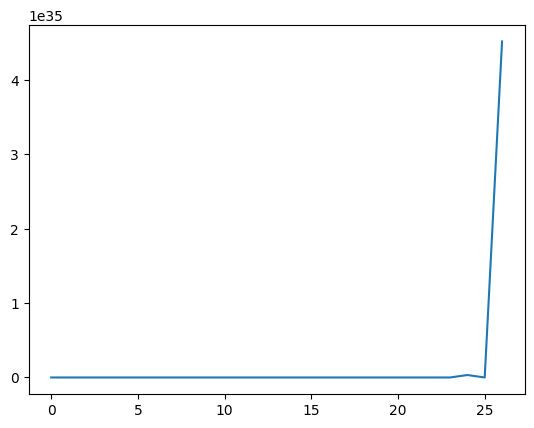

In [42]:
# Training transforms: augmentation + normalization
transform_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Test transforms: only normalization (no augmentation)
transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)
## Don't change the remaining code
if __name__ == "__main__":
    # Load the downsampled CIFAR-10 dataset
    print("Loading dataset...")
    dataset = load_dataset("r-three/cifar10-5class-5k")

    # Class names
    class_names = ["airplane", "automobile", "bird", "cat", "deer"]
    num_classes = len(class_names)

    print(f"\nDataset Info:")
    print(f"Train samples: {len(dataset['train'])}")
    print(f"Test samples: {len(dataset['test'])}")
    print(f"Classes: {class_names}")

    # Create datasets
    train_dataset = CIFAR5Dataset(dataset["train"], transform=transform_train)
    test_dataset = CIFAR5Dataset(dataset["test"], transform=transform_test)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, batch_size=args["batch_size"], shuffle=True
    )
    test_loader = DataLoader(test_dataset, batch_size=args["batch_size"], shuffle=False)
    visualize_cifar5(test_loader)

    print("Creating model...")
    model = CNN(num_classes=args["num_classes"])
    # Move the model to the device
    model = model.to(args["device"])

    train_losses, val_loss, val_acc = train(model, train_loader, test_loader, args)
    plt.plot(train_losses)

### Reflection Questions
 (Not graded)

After implementing convolutions from scratch and as matrix operations, consider these questions:

**Efficiency and Parameters:**
1. A fully connected layer connecting a 32 $\times$ 32 RGB image to 64 output features has how many parameters? Compare this to a Conv2d(3, 64, 3) layer. Why is the convolutional layer so much more parameter-efficient?

2. What makes convolutional layers "translation equivariant"? Why is this property useful for image tasks but might be less relevant for other types of data?

**Storage and Memory:**

3. Consider storing intermediate activations during backpropagation. For a 224 $\times$ 224 input image passing through a Conv2d(3, 64, 3) versus a fully connected layer with 64 outputs - which requires more memory to store activations?

5. When implementing convolution as a matrix-vector product, the matrix is very sparse (mostly zeros). Modern implementations don't actually create this full matrix. Why not? What memory savings does this provide for a 1000 $\times$ 1000 image with a 3 $\times$ 3 kernel?

**Architecture Design:**

6. Why do CNNs typically use small kernels (3 $\times$ 3, 5 $\times$ 5) stacked in multiple layers rather than one large kernel (e.g., 11 $\times$ 11) in a single layer? Consider both receptive field and parameter count.


# Collaboration / External Help
Disclose any help you used (LLM usage, blogs, search, Github links, etc) and collaborations with your classmates. If you  completed the homework on your own, you can leave this part empty.

> TODO